In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets as ds
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load datasets
X_train, y_train = ds.load_svmlight_file('data/a9a')
X_train = X_train.todense()
X_train = np.array(X_train)

X_test, y_test = ds.load_svmlight_file('data/a9a.t')
X_test = X_test.todense()
X_test = np.array(X_test)
#X_test 123rd col: all zeros
X_test = np.concatenate((X_test, np.zeros((X_test.shape[0], 1))), axis=1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32561, 123), (32561,), (16281, 123), (16281,))

In [41]:
#param init:all zeros
def zeroInit():
    return np.zeros(X_train.shape[1])

def randomInit():#normal (Gaussian) distribution
    return np.random.normal(0, 0.1, X_train.shape[1])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# define cross entropy error measure
def loss(X, y, w, reg):
    return 1 / X.shape[0] * np.sum(np.log(1+np.exp(-y * np.dot(X, w)))) + reg / 2 * np.sum(np.square(w))

# define metric
def accuracy(y_true, y_pred):
    return np.sum(y_true==y_pred) / len(y_true)

#calculate gradients
def gradient(X, y, w, reg):
    res = reg * w - 1/X.shape[0] * np.dot(X.T, y * np.exp(-y*np.dot(X, w))/(1 + np.exp(-y*np.dot(X, w))))
    return res

# define prediction
def predict(X, w, threshold=0):
    res = np.dot(X, w)
    res[res>=threshold] = 1
    res[res<threshold] = -1
    return res

def getBatch(X, y, batch_size):
    idx = np.random.choice(X.shape[0], batch_size, replace=False)
    return X[idx], y[idx]

# for plotting curves
class RecordContainer(object):
    def __init__(self, X_test, y_test):
        self.train_history = {}
        self.train_history['loss'] = []
        self.train_history['accuracy'] = []
        self.test_history = {}
        self.test_history['loss'] = []
        self.test_history['accuracy'] = []      
        self.X_test = X_test
        self.y_test = y_test
        
    def recordLoss(self, X_batch, y_batch, w, threshold, reg):
        train_loss = loss(X_batch, y_batch, w, reg)
        self.train_history['loss'].append(train_loss)
        test_loss = loss(self.X_test, self.y_test, w, reg)
        self.test_history['loss'].append(test_loss)

        train_accuracy = accuracy(y_batch, predict(X_batch, w, threshold))
        self.train_history['accuracy'].append(train_accuracy)
        test_accuracy = accuracy(y_test, predict(X_test, w, threshold))
        self.test_history['accuracy'].append(test_accuracy)
        return train_loss, test_loss, train_accuracy, test_accuracy
    
    def getBestTestAccuracy(self):
        return max(self.test_history['accuracy'])
    
    def getBestTestLoss(self):
        return min(self.test_history['loss'])
    
    def plotting(self, ptype='loss', title = ''):#loss/accuracy
        plt.title(title)
        plt.xlabel('iteration number')
        plt.ylabel(ptype)
        plt.plot(range(len(self.train_history[ptype])), self.train_history[ptype],'r', label='train '+ptype)  
        plt.plot(range(len(self.test_history[ptype])), self.test_history[ptype],'b',label='test '+ptype)  
        plt.legend()
        plt.grid()
        plt.show()

In [42]:
class NAGOptimizer(object):#Nesterov accelerated gradient
    def __init__(self, rho = 0.9):
        self.v = 0
        self.rho = rho
    
    def getNextDirection(self, X_train, y_train, w, learning_rate, reg, cur_run):
        dw = gradient(X_train, y_train, w, reg)
        prev_v = self.v
        self.v = self.v * self.rho - learning_rate * dw
        return -self.rho * prev_v + (1 + self.rho) * self.v

class RMSPropOptimizer(object):
    def __init__(self, decay_rate = 0.9):
        self.grad_squared = 0
        self.decay_rate = decay_rate
    
    def getNextDirection(self, X_train, y_train, w, learning_rate, reg, cur_run):
        dw = gradient(X_train, y_train, w, reg)
        self.grad_squared = self.decay_rate * self.grad_squared + (1 - self.decay_rate) * dw * dw
        return -learning_rate * dw / (np.sqrt(self.grad_squared) + 1e-7)

class AdaDeltaOptimizer(object):
    def __init__(self, gamma = 0.95):
        self.numerator = 0
        self.denominator = 0
        self.gamma = gamma
    
    def getNextDirection(self, X_train, y_train, w, learning_rate, reg, cur_run):
        dw = gradient(X_train, y_train, w, reg)
        self.denominator = self.gamma * self.denominator + (1 - self.gamma) * dw * dw
        res = -np.sqrt((self.numerator + 1e-6)/(self.denominator + 1e-6)) * dw
        self.numerator = self.gamma * self.numerator + (1 - self.gamma) * res * res
        return res
     
class AdamOptimizer(object):
    def __init__(self, beta1 = 0.9, beta2 = 0.999):
        self.first_moment = 0
        self.second_moment = 0
        self.beta1 = beta1
        self.beta2 = beta2
        
    def getNextDirection(self, X_train, y_train, w, learning_rate, reg, cur_run):
        dw = gradient(X_train, y_train, w, reg)
        self.first_moment = self.beta1 * self.first_moment + (1 - self.beta1) * dw
        self.second_moment = self.beta2 * self.second_moment + (1 - self.beta2) * dw * dw
        first_unbias = self.first_moment / (1 - self.beta1 ** cur_run)
        second_unbias = self.second_moment / (1 - self.beta2 ** cur_run)
        return -learning_rate * first_unbias / (np.sqrt(second_unbias) + 1e-7)

iter 500: 0.426450269279 0.428988671638 0.788956452306
iter 1000: 0.399105390109 0.390338503627 0.819728517904
iter 1500: 0.352079578599 0.373257449136 0.828020391868
iter 2000: 0.391068251134 0.363242534897 0.831951354339
iter 2500: 0.379663665503 0.356477823914 0.834960997482
iter 3000: 0.3391034586 0.351557775479 0.837602112892
iter 3500: 0.363391458162 0.347839847154 0.839014802531
iter 4000: 0.397804822317 0.34485041016 0.840427492169
iter 4500: 0.275336830427 0.342305881387 0.841287390209
best NAG test loss:  0.340123763701
best NAG test accuracy:  0.842638658559


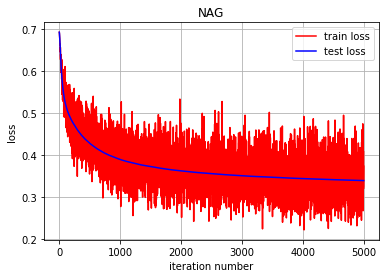

iter 500: 0.37483372398 0.358354967305 0.834223942018
iter 1000: 0.365354392692 0.334502561107 0.844911246238
iter 1500: 0.374091648634 0.327785449926 0.848903629998
iter 2000: 0.267304962192 0.325695044354 0.850377740925
iter 2500: 0.422118548859 0.324567492983 0.851360481543
iter 3000: 0.258207474858 0.324035782414 0.851544745409
iter 3500: 0.405123846837 0.323897235128 0.85148332412
iter 4000: 0.310841385907 0.32390306568 0.850623426079
iter 4500: 0.284187193737 0.324078922637 0.850623426079
best RMSProp test loss:  0.323753158414
best RMSProp test accuracy:  0.852281800872


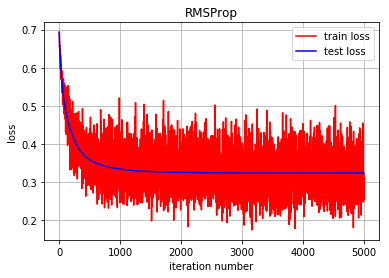

iter 500: 0.361882955094 0.330829752019 0.846201093299
iter 1000: 0.376740889282 0.325011078863 0.849395000307
iter 1500: 0.350979437442 0.323913338802 0.851114796388
iter 2000: 0.280603260249 0.323991760726 0.851114796388
iter 2500: 0.345396145695 0.324388336492 0.851667587986
iter 3000: 0.312942862545 0.324341789779 0.849087893864
iter 3500: 0.345550828886 0.324792433525 0.849579264173
iter 4000: 0.378584416514 0.325936978876 0.847675204226
iter 4500: 0.337759911762 0.324831710372 0.848965051287
best AdaDelta test loss:  0.32373672841
best AdaDelta test accuracy:  0.852343222161


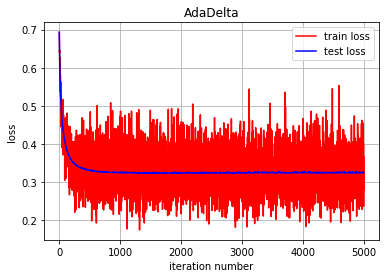

iter 500: 0.460896294351 0.374796906709 0.832197039494
iter 1000: 0.361531159802 0.343501959761 0.842392973405
iter 1500: 0.342655866983 0.332956652925 0.848166574535
iter 2000: 0.347399285823 0.328353257024 0.849210736441
iter 2500: 0.375113513115 0.326245509056 0.850254898348
iter 3000: 0.326554800542 0.325063283297 0.850562004791
iter 3500: 0.358906584243 0.324391158586 0.850254898348
iter 4000: 0.322276404342 0.324137602529 0.850684847368
iter 4500: 0.19205252749 0.324047816084 0.850869111234
best Adam test loss:  0.323954683263
best Adam test accuracy:  0.851544745409


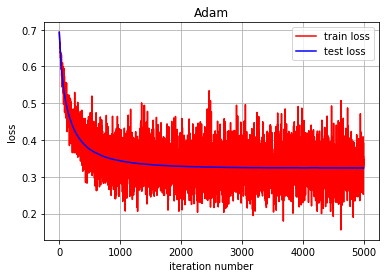

In [44]:
learning_rate = 1e-3
iter_num = 5000
threshold = 0
reg = 0
batch_size = 100
verbose = 500

#select optimizer
instance_list = [NAGOptimizer(), RMSPropOptimizer(), AdaDeltaOptimizer(), AdamOptimizer()]
label_list = ['NAG','RMSProp','AdaDelta', 'Adam']

recorder_list = []
for i in range(len(instance_list)):
    recorder_list.append(RecordContainer(X_test, y_test))

for opt_idx in range(len(instance_list)):
    #initialize w
#     w = randomInit()
    w = zeroInit()

    instance = instance_list[opt_idx]
    recorder = recorder_list[opt_idx]
    label = label_list[opt_idx]

    #start training process
    for i in range(1, iter_num):
        X_batch, y_batch = getBatch(X_train, y_train, batch_size)
        train_loss, test_loss, train_accuracy, test_accuracy = recorder.recordLoss(X_batch, y_batch, w, threshold, reg)
        if i % verbose == 0:
            print('iter ' + str(i) + ':', train_loss, test_loss, test_accuracy)
        w += instance.getNextDirection(X_batch, y_batch, w, learning_rate,reg, i)
    print('best '+label+' test loss: ', recorder.getBestTestLoss())
    print('best '+label+' test accuracy: ', recorder.getBestTestAccuracy())

    # plotting loss
    recorder.plotting('loss', label)
#     recorder.plotting('accuracy', label)

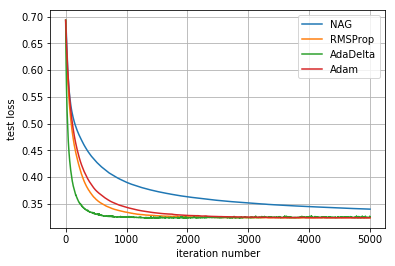

In [45]:
# plt.title(title)
plt.xlabel('iteration number')
plt.ylabel('test loss')
for opt_idx in range(len(recorder_list)):
    recorder = recorder_list[opt_idx]
    label = label_list[opt_idx]
    plt.plot(range(len(recorder.test_history['loss'])), recorder.test_history['loss'],label = label)  
plt.legend()
plt.grid()
plt.show()

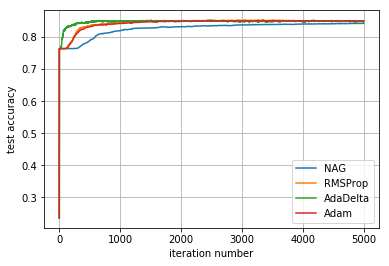

In [46]:
# plt.title(title)
plt.xlabel('iteration number')
plt.ylabel('test accuracy')
for opt_idx in range(len(recorder_list)):
    recorder = recorder_list[opt_idx]
    label = label_list[opt_idx]
    plt.plot(range(len(recorder.test_history['accuracy'])), recorder.test_history['accuracy'],label = label)  
plt.legend()
plt.grid()
plt.show()